In [1]:
# Imports
import re
import os
import cv2
import sys
import json
import torch
import monai
import random
import argparse
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from time import time, sleep
from datetime import datetime
from skimage import transform
from matplotlib import pyplot as plt

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '0_utils'))
if not dir2 in sys.path: sys.path.append(dir2)

from dataload_handler import DataLoaderHandler
from checkpoint_handler import CheckpointHandler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
import argparse

parser = argparse.ArgumentParser()

# Inspired by orginal code from the MedSAM/extensions/point_prompt

# 1. Add the anatomy on which we will fine-tune
parser.add_argument(
    '--anatomy',
    type=str,
    help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.',
    required=True
)

_StoreAction(option_strings=['--anatomy'], dest='anatomy', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=True, help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.', metavar=None)

In [3]:
args = parser.parse_args(
    ['--anatomy', 'CTVn']
)

anatomy = args.anatomy

## Setup classes for loading up the stuff

In [4]:
lowres = True
save_dir = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres', anatomy)
checkpoint_path = os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth')
model_path = os.path.join(save_dir, 'checkpoint_best.pth')
data_split = os.path.join(save_dir, 'data_splits.json')
img_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)
batch_size = 1
num_workers = 16

use_boxes = True
use_positive_points = False

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_dir), f"Raw data {img_dir} does not exist."
assert os.path.exists(gt_dir), f"Ground truth data {gt_dir} does not exist."

In [5]:
dlh = DataLoaderHandler(save_dir = save_dir,
                        image_dir = img_dir,
                        gt_dir = gt_dir,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        data_aug = False,
                        max_points = 0,
                        box_padding = 5,
                        max_box_points = 5)
dlh.load_split_from_json()
dlh.setup_specific_dataloader('validation')
dlh.validation_image_ids

Dataset size (6.6 GiB) fits in cache limit (20 GiB). Allocating space to cache all 6718 samples.


{2, 10, 11, 16, 38, 42, 43, 46, 49, 51, 56, 57, 66, 71, 73, 74, 77, 79, 92, 93}

In [6]:
cph = CheckpointHandler(save_dir, checkpoint_path, device)
if cph.checkpoint_exists():
    model, optimizer, epoch, best_loss = cph.load_checkpoint()
    print(f'Loaded the model for anatomy {anatomy} from epoch {epoch}')

Loaded the model for anatomy CTVn from epoch 53


## Main validaiton loop

In [7]:
import pandas as pd

# create a pandas dataframe to store the name, axis, dice, jaccard, volume_similarity, apl, surface_distance, and hausdorff_distance

df = pd.DataFrame(columns=['name', 'axis', 'dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance'])

# load in the processed data if it already exists
if os.path.exists(os.path.join(save_dir, 'validation.csv')):
    df = pd.read_csv(os.path.join(save_dir, 'validation.csv'))

In [8]:
import SimpleITK as sitk
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

length_of_val_loader = len(dlh.val_loader)

# iterate through the validation loader
for i, batch in tqdm(enumerate(dlh.val_loader), total=length_of_val_loader):

    # check if we have already processed this name and axis
    if batch["image_name"][0] in df.name.values and batch["axis"].item() in df.axis.values:
        continue

    # Get data
    image = batch["image"].to(device)
    gt2D = batch["gt2D"].to(device)
    # coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
    boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])
    axis = batch["axis"].squeeze() # ([B])

    medsam_preds = []
    medsam_segs = []

    for b in torch.unique(boxes_torch.squeeze().reshape(-1, batch_size, 4), dim=0):
        b = b.reshape(batch_size, 1, 4)
        # print(b)
        medsam_lite_pred = model(image, None, b)
        medsam_seg_prob = torch.sigmoid(medsam_lite_pred)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        medsam_preds.append(medsam_lite_pred.detach().cpu())
        medsam_segs.append(medsam_seg)

    medsam_preds = torch.tensor(np.stack(medsam_preds))
    medsam_segs = torch.tensor(np.stack(medsam_segs))

    # do an OR operation on the medsam_segs
    medsam_seg = medsam_segs.sum(dim=0)

    # Get evaluation metrics
    y_gt_sitk = sitk.GetImageFromArray(gt2D[0].detach().cpu().numpy().astype(np.uint8))
    ypred_sitk = sitk.GetImageFromArray(medsam_seg[None, :, :].numpy().astype(np.uint8))

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
                
    dice = overlap_measures_filter.GetDiceCoefficient()
    jaccard = overlap_measures_filter.GetJaccardCoefficient()
    volume_similarity = overlap_measures_filter.GetVolumeSimilarity()

    apl = compute_metric_total_apl(y_gt_sitk, ypred_sitk)
    surface_dsc = compute_surface_dsc(y_gt_sitk, ypred_sitk)
    hd = compute_metric_hd(y_gt_sitk, ypred_sitk)

    # add metrics to dataframe

    new_record = pd.DataFrame([
        {'name': batch["image_name"][0], 'axis': batch["axis"].item(), 'dice': dice, 'jaccard': jaccard, 'volume_similarity': volume_similarity, 'apl': apl, 'surface_distance': surface_dsc, 'hausdorff_distance': hd}
    ])

    df = pd.concat([df, new_record], ignore_index=True)

    if i % 10 == 0:
        # save the dataframe to a csv file
        df.to_csv(os.path.join(save_dir, 'validation.csv'), index=False)



100%|██████████| 6718/6718 [27:32<00:00,  4.07it/s] 


## plot the metrics per axis and total

In [10]:
df

,name,axis,dice,jaccard,volume_similarity,apl,surface_distance,hausdorff_distance
0,CT_zzAMLART_093-235.npy,1,0.880810,0.787007,0.046019,21.0,0.937107,6.403124
1,CT_zzAMLART_092-218.npy,2,0.888811,0.799874,0.113287,30.0,0.865772,6.403124
2,CT_zzAMLART_016-286.npy,2,0.657939,0.490245,-0.160457,138.0,0.521021,15.811388
3,CT_zzAMLART_074-212.npy,2,0.755295,0.606807,-0.127084,50.0,0.780000,11.661904
4,CT_zzAMLART_074-115.npy,0,0.913500,0.840774,-0.017785,0.0,1.000000,2.236068
...,...,...,...,...,...,...,...,...
4595,CT_zzAMLART_056-136.npy,0,0.862338,0.757991,0.005195,16.0,0.906318,7.211103
4596,CT_zzAMLART_051-070.npy,0,0.877551,0.781818,0.067055,0.0,0.997763,3.000000
4597,CT_zzAMLART_074-151.npy,0,0.901763,0.821101,-0.105793,0.0,1.000000,2.828427
4598,CT_zzAMLART_057-138.npy,0,0.890710,0.802956,0.036430,0.0,0.966555,2.828427


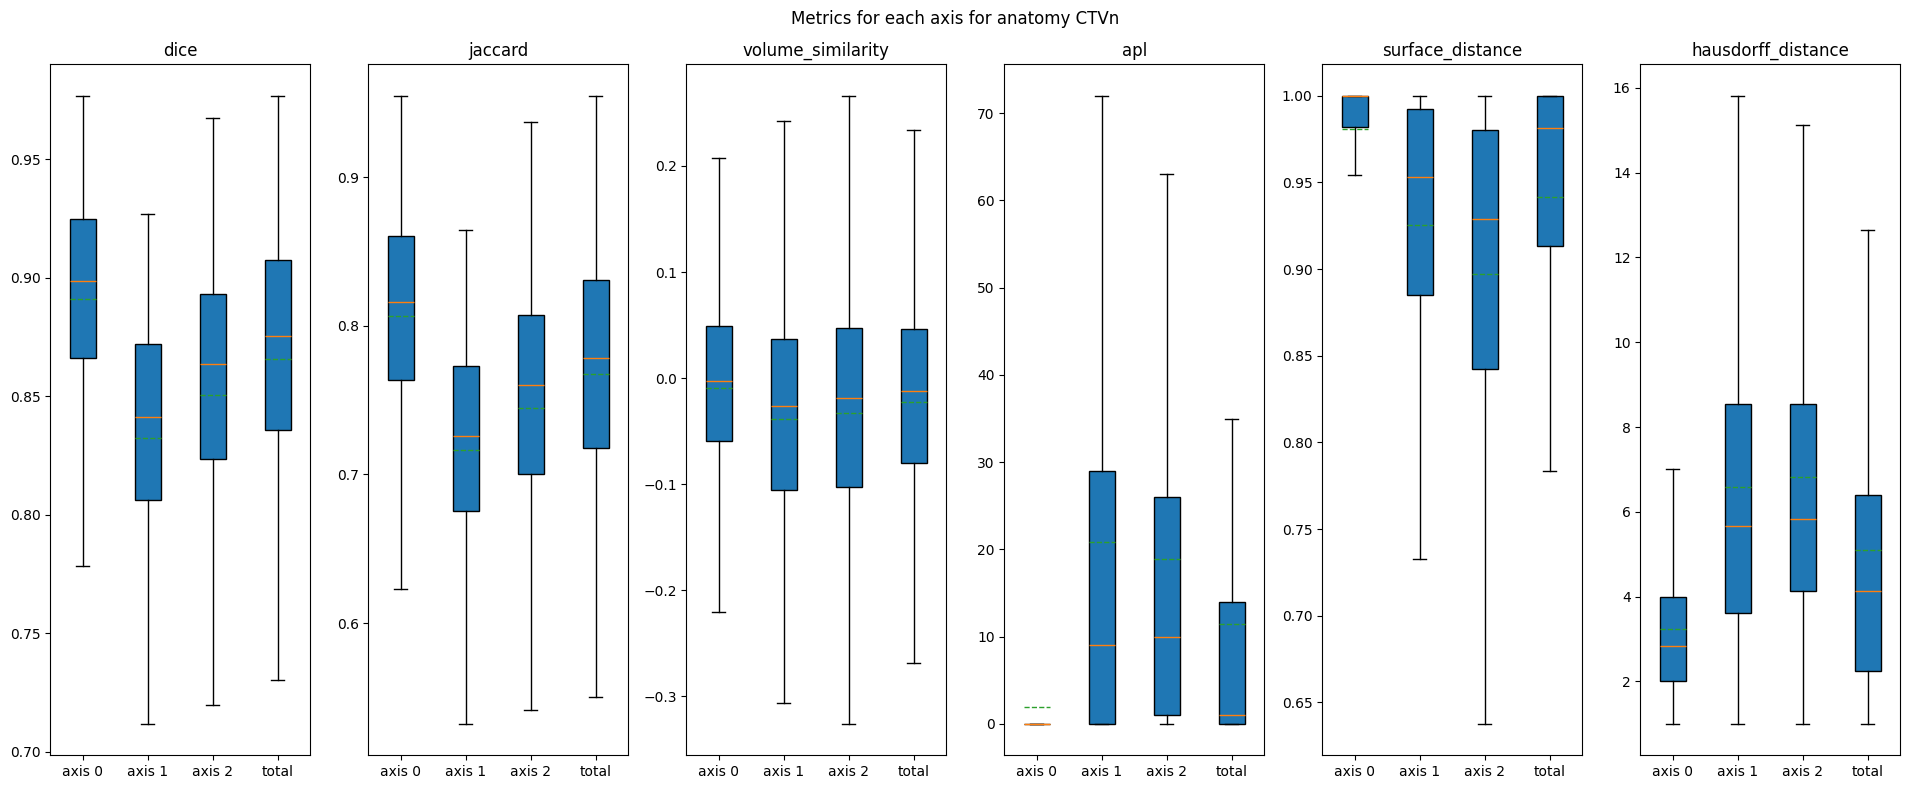

In [36]:
# for each axis, plot the metrics

metrics = ['dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance']

ncols = len(metrics)
nrows = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2*1.6, nrows*5*1.6))
axs = axs.reshape(nrows, ncols)

for i in range(ncols):
    # get the column values
    column = metrics[i]

    # set the title of the cell to the metric type
    axs[0, i].set_title(column)

    # for each axis, plot the metric
    for axis in range(3):
        data = df[df.axis == axis]
        
        # for each axis, plot the boxplot with each axis being a different point on the x-axis labelled with axis-0, axis-1, axis-2.
        axs[0, i].boxplot(data[column], positions=[axis], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

    # now, we plot the total score across all axis

    axs[0, i].boxplot(df[column], positions=[3], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))
    axs[0, i].set_xticklabels(['axis 0', 'axis 1', 'axis 2', 'total'])
        
    
plt.suptitle(f'Metrics for each axis for anatomy {anatomy}')
plt.tight_layout()
plt.show()